In [1]:
# -*- coding: utf-8 -*-
import xarray as xr
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import glob
import calendar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xesmf as xe
# import dask
from datetime import datetime
%matplotlib inline

In [2]:
# Path to all models
path_ecearth = '/esarchive/exp/CMIP6/dcppA-hindcast/ec-earth3/cmip6-dcppA-hindcast_i1p1/DCPP/EC-Earth-Consortium/EC-Earth3/dcppA-hindcast/r2i1p1f1/SImon/siconc/gn/v20200101/'
path_norcpm1_1 = '/esarchive/exp/CMIP6/dcppA-hindcast/norcpm1/cmip6-dcppA-hindcast_i1p1/DCPP/NCC/NorCPM1/dcppA-hindcast/r2i1p1f1/SImon/siconc/gn/v20200101/'
path_norcpm1_2 = '/esarchive/exp/CMIP6/dcppA-hindcast/norcpm1/cmip6-dcppA-hindcast_i2p1/DCPP/NCC/NorCPM1/dcppA-hindcast/r2i2p1f1/SImon/siconc/gn/v20200101/'
path_canesm5 = '/esarchive/exp/CMIP6/dcppA-hindcast/canesm5/cmip6-dcppA-hindcast_i1p2/DCPP/CCCma/CanESM5/dcppA-hindcast/r2i1p2f1/SImon/siconc/gn/v20200101/'
path_ipsl = '/esarchive/exp/CMIP6/dcppA-hindcast/ipsl-cm6a-lr/cmip6-dcppA-hindcast_i1p1/DCPP/IPSL/IPSL-CM6A-LR/dcppA-hindcast/r2i1p1f1/SImon/siconc/gn/v20200101/'
path_miroc = '/esarchive/exp/CMIP6/dcppA-hindcast/miroc6/cmip6-dcppA-hindcast_i1p1/DCPP/MIROC/MIROC6/dcppA-hindcast/r2i1p1f1/SImon/siconc/gn/v20200101/'
path_mpi = '/esarchive/exp/CMIP6/dcppA-hindcast/mpi-esm1-2-hr/cmip6-dcppA-hindcast_i1p1/DCPP/MPI-M/MPI-ESM1-2-HR/dcppA-hindcast/r2i1p1f1/SImon/siconc/gn/v20200101/'

## Open DataSets

In [4]:
# EC-EARTH #
sic_ecearth = xr.open_dataset(path_ecearth + 'siconc_SImon_EC-Earth3_dcppA-hindcast_s1962-r2i1p1f1_gn_196211-196310.nc')
print('Size of the file: ', sic_ecearth.nbytes/1e6, 'Mb')

Size of the file:  9.304863 Mb


In [5]:
# NORCPM1_1 #
sic_norcpm1_1 = xr.open_dataset(path_norcpm1_1 + 'siconc_SImon_NorCPM1_dcppA-hindcast_s1962-r2i1p1f1_gn_196210-197212.nc')

In [6]:
# NORCPM1_2 #
sic_norcpm1_2 = xr.open_dataset(path_norcpm1_2 + 'siconc_SImon_NorCPM1_dcppA-hindcast_s1962-r2i2p1f1_gn_196210-197212.nc')

In [7]:
# CanESM5 #
sic_canesm5 = xr.open_dataset(path_canesm5 + 'siconc_SImon_CanESM5_dcppA-hindcast_s1961-r2i1p2f1_gn_196201-197112.nc')

In [8]:
# IPSL-CM6 #
sic_ipsl = xr.open_dataset(path_ipsl + 'siconc_SImon_IPSL-CM6A-LR_dcppA-hindcast_s1961-r2i1p1f1_gn_196201-197112.nc')

In [9]:
# MIROC6 # 
sic_miroc = xr.open_dataset(path_miroc + 'siconc_SImon_MIROC6_dcppA-hindcast_s1962-r2i1p1f1_gn_196211-197212.nc')

In [10]:
# MPI-ESM1 #
sic_mpi = xr.open_dataset(path_mpi + 'siconc_SImon_MPI-ESM1-2-HR_dcppA-hindcast_s1962-r2i1p1f1_gn_196211-197212.nc')

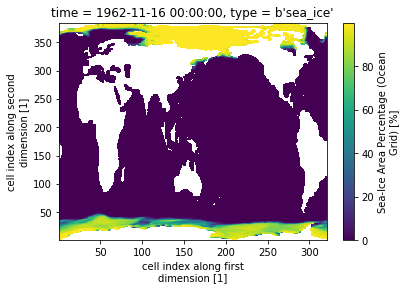

In [5]:
sic_nor1 = sic_norcpm1['siconc']
# sic_nor1
sic_nor1.sel(time='1962-11-16').plot()

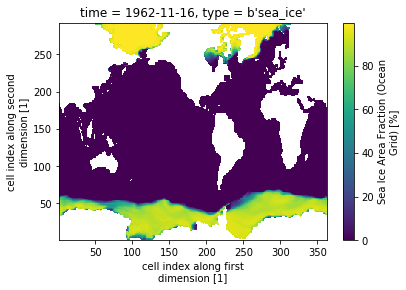

In [6]:
sic_ec = sic_ecearth['siconc']
first_month = sic_ec.sel(time='1962-11-16')
first_month.plot()

In [ ]:
# NSIDC 0051 monthly data #
dfile = '/esarchive/obs/nasa/nsidc0051_gsfc_nasateam_seaice/processed/north/monthly_mean/siconc_r1i1p1_mon_197901_nh-psn25.nc'
sic_nsidc = xr.open_dataset(dfile)

In [48]:
# SELECT DATA TO BE PLOTTED
all_models = [sic_ecearth, sic_norcpm1_1, sic_norcpm1_2, sic_canesm5, sic_ipsl, sic_miroc, sic_mpi, sic_nsidc]


Reuse existing file: nearest_s2d_292x362_181x361_peri.nc
Reuse existing file: nearest_s2d_384x320_361x181_peri.nc
Reuse existing file: nearest_s2d_384x320_361x181_peri.nc
Reuse existing file: nearest_s2d_291x360_181x361_peri.nc
Reuse existing file: nearest_s2d_332x362_181x361_peri.nc
Reuse existing file: nearest_s2d_256x360_181x361_peri.nc
Reuse existing file: nearest_s2d_404x802_181x361_peri.nc
Reuse existing file: nearest_s2d_304x448_181x361_peri.nc


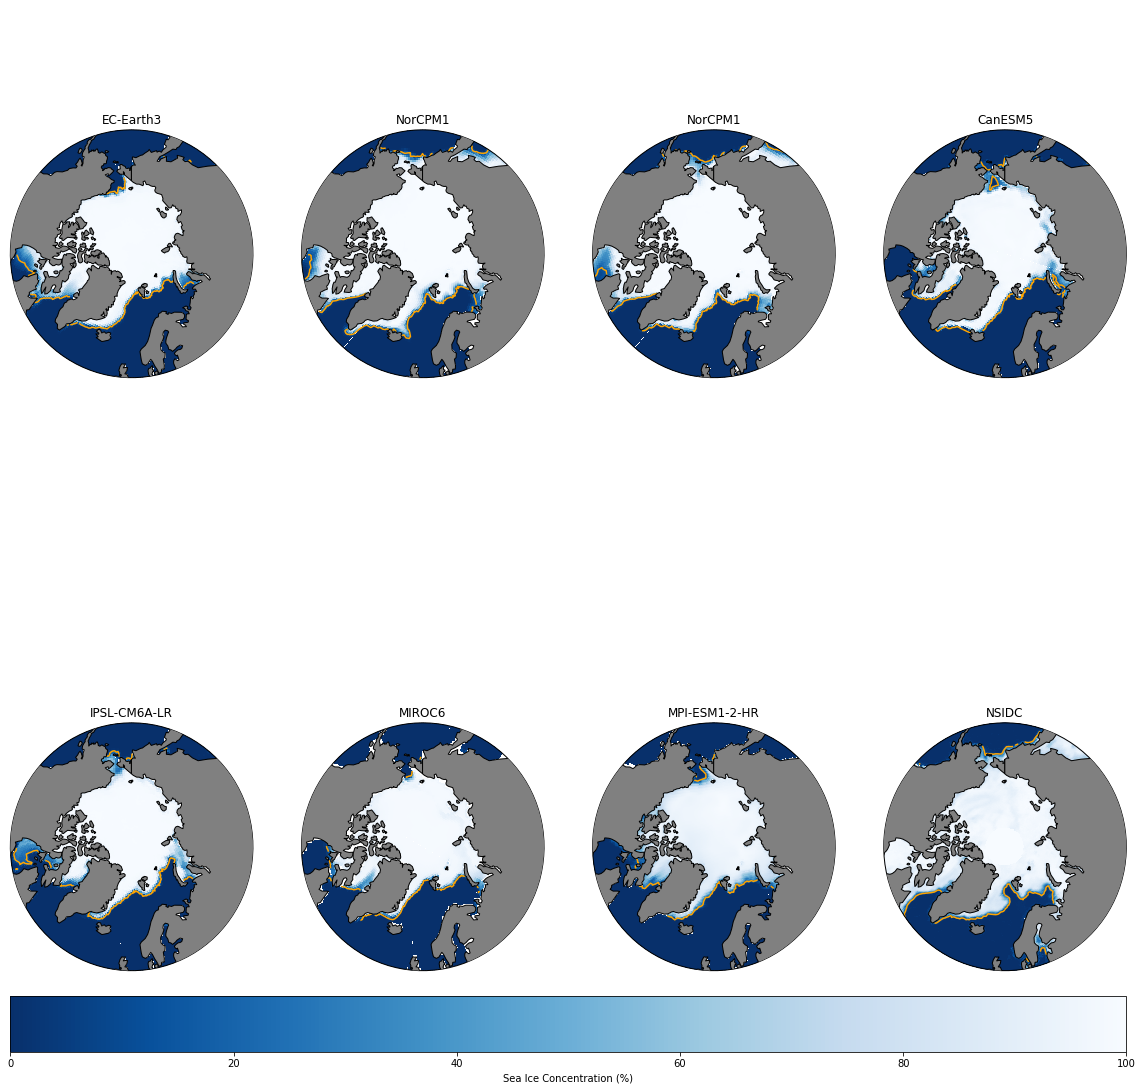

In [50]:
# ARCTIC # 
#~~~~~~~~#
# fig1 = plt.figure(figsize=(20,20))
fig1, axes = plt.subplots(figsize=(20,20), constrained_layout=False) #, sharex=True, sharey=True)

i = 1
index = 0
for m in all_models:
    index += 1
    axes.set_axis_off()

    # Select VAR
    sic_model = m['siconc']

    # Deal with diferent names for latitude and longitude coordinates
    if m is not sic_nsidc and np.str(m.source_id) == 'IPSL-CM6A-LR':
        latitude = sic_model.nav_lat
        longitude = sic_model.nav_lon
    else:
        latitude = sic_model.latitude
        longitude = sic_model.longitude

    # Select MONTH
    if m is sic_nsidc:
        first_month = sic_model
    else:
        first_month = sic_model.sel(time='1962-11-16')
    
    # New evenly spaced, monotonically increasing lat-lon grid for regridding the sea ice
    # concentration for the contour plot (otherwise the contour will reverse on itself)
    res_new = 1 # degrees; the resolution of the new grid
    lat_new = -90 + np.arange(1+(2*90)/res_new) # only go from 80S to 80N

    lon_new = np.arange(1+(360)/res_new)
    lon_new, lat_new = np.meshgrid(lon_new,lat_new)

    ice_edge_conc = 15 # the concentration threshold for the sea ice edge

    # Load in the sea ice concentration for the months I want,
    # average it over those months, and find its size
    
    data = np.squeeze(np.array(first_month))
    ndim0 = np.size(data,axis=0)
    ndim1 = np.size(data,axis=1)

    # Regrid
    data_new = data
    lat_temp = latitude.copy()
    lon_temp = longitude.copy()
    method = np.str('bilinear')
    method = np.str('nearest_s2d')

    # Make sure the dimensions of the new grid are in the right order
    lat_temp = lat_new.copy()
    lon_temp = lon_new.copy()
    if ndim0>ndim1:
        lat_temp = np.transpose(lat_temp)
        lon_temp = np.transpose(lon_temp)

    lat_temp2 = latitude.copy()
    lon_temp2 = longitude.copy()
    # lat_temp2[np.abs(lat_temp2)>90] = np.nan
    # lon_temp2[np.abs(lon_temp2)>360] = np.nan #-- > ERROR because it is not a list

    # Create the xarray datasets to feed into the xesmf regridder
    ds_in = xr.Dataset({'lat': (['x','y'],lat_temp2),
                        'lon': (['x','y'],lon_temp2)})
    ds_out = xr.Dataset({'lat': (['x','y'],lat_temp),
                            'lon': (['x','y'],lon_temp)})

    # Regrid the data
    f = xe.Regridder(ds_in, ds_out, method, periodic=True, reuse_weights=True)
    data_new = f(data)

    # A data mask for SouthPolarStereo plots
    # mydata = ma.masked_where(latitude>0.,data.copy())
    # mydata_new = ma.masked_where(lat_temp>0.,data_new.copy())

    # A data mask for NortPolarStereo plots
    mydata = ma.masked_where(latitude<0.,data.copy())
    mydata_new = ma.masked_where(lat_temp<0.,data_new.copy())

    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
        
    # Make a pcolor plot of sea ice concentration, and contour the sea ice edge
    ax = fig1.add_subplot(2, 4, index, projection = ccrs.NorthPolarStereo()) # 5, 4
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='black',facecolor='Grey')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
    # ax.set_extent([0.005, 360, -90, -50], crs=ccrs.PlateCarree()) # South Pole
    this = ax.pcolormesh(longitude,latitude,mydata,transform=ccrs.PlateCarree(),cmap = plt.cm.Blues_r, vmin=0, vmax=100)
    this2 = ax.contour(lon_temp,lat_temp,mydata_new,[ice_edge_conc],transform=ccrs.PlateCarree(),colors='orange')
    if m is sic_nsidc:
        plt.title('NSIDC')    
    else:
        plt.title(np.str(m.source_id))
    
fig1.colorbar(this, ax=axes, orientation='horizontal', fraction = 0.09, label = 'Sea Ice Concentration (%)')#, shrink=-0.6)
plt.show()
# plt.savefig('example.png')